Import libraries, set up global variables

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

from clean_data import clean_data, fill_missing_values, filter_timeseries
from eda import plot_timeseries
from load_data import get_data_from_uci

DATA_PATH = "./data/household_power_consumption.txt"
START_DATE = "2008-01-01"
END_DATE = "2008-01-21"
WEEK_PERIOD = 60 * 24 * 7
DAY_PERIOD = 60 * 24
H12_PERIOD = 60 * 12
HOUR_PERIOD = 60

plt.rcParams["savefig.dpi"] = 300

Load and prepare data

In [2]:
get_data_from_uci(DATA_PATH)
X = clean_data(DATA_PATH)
X = filter_timeseries(X, START_DATE, END_DATE)
X = fill_missing_values(X)

Number of missing rows: 1
Filling missing values with the previous non-missing value


New plot saved to ./figs/timeseries.png


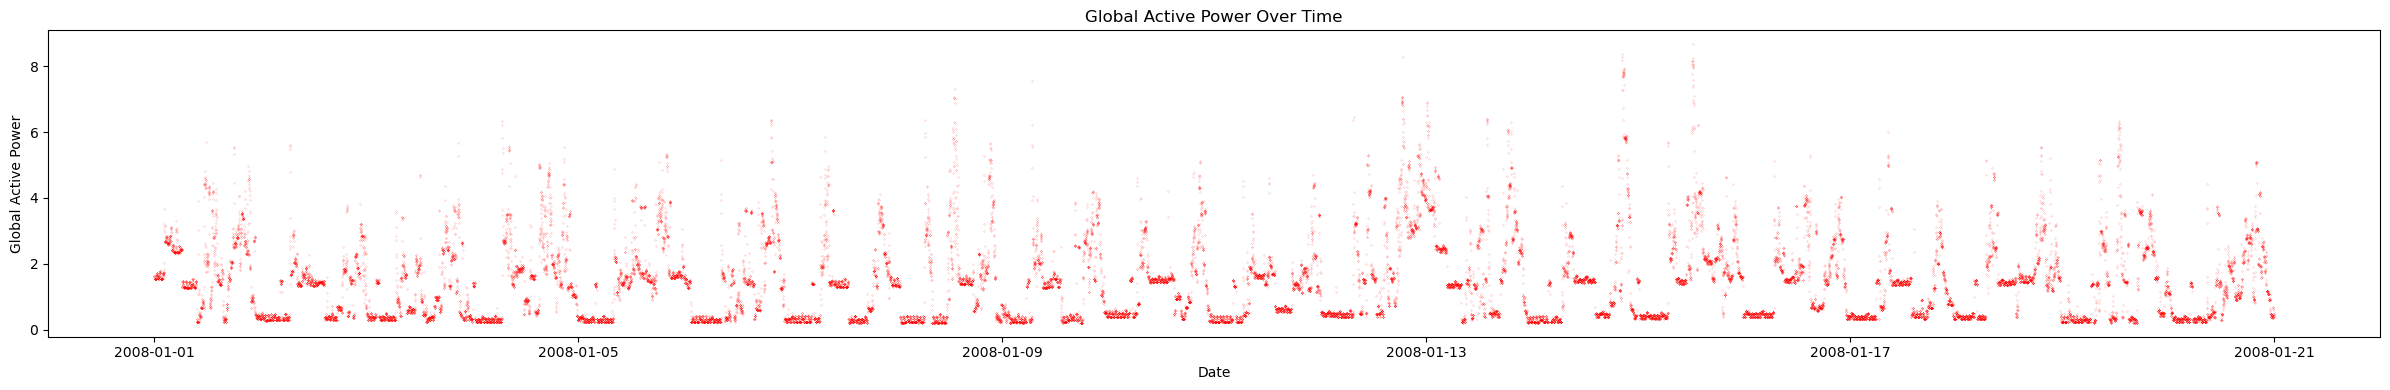

In [3]:
plt = plot_timeseries(X)

Convert to pandas for statsmodels work

In [4]:
X = X.to_pandas()
X.set_index("datetime", inplace=True)

Weekly decomposition

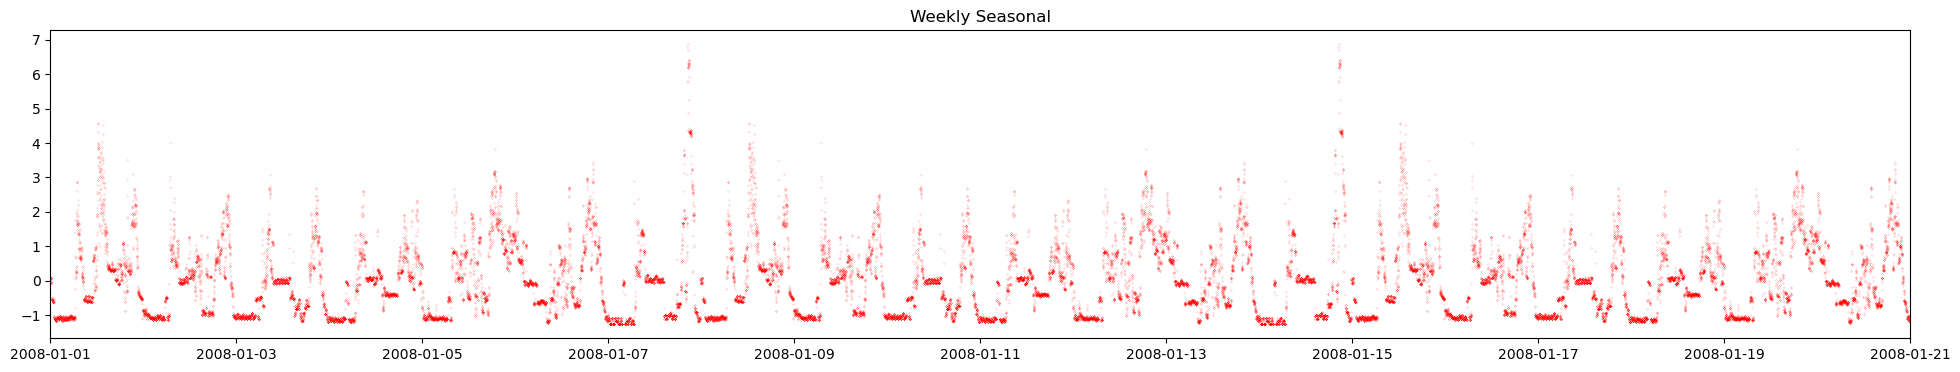

In [5]:
weekly_decomposition = seasonal_decompose(
        X, model="additive", period=WEEK_PERIOD, two_sided=False
    )
weekly_trend = weekly_decomposition.trend
# weekly_decomposition.plot()
Y = weekly_decomposition.seasonal.to_frame(name="power")

fig, ax = plt.subplots(figsize=(24, 4))
ax.set_xlim(np.datetime64(START_DATE), np.datetime64(END_DATE))
ax.scatter(Y.index, Y["power"], color="red", s=0.01)
plt.title("Weekly Seasonal")
plt.savefig("./figs/weekly_decomposition.png")


Daily decomposition

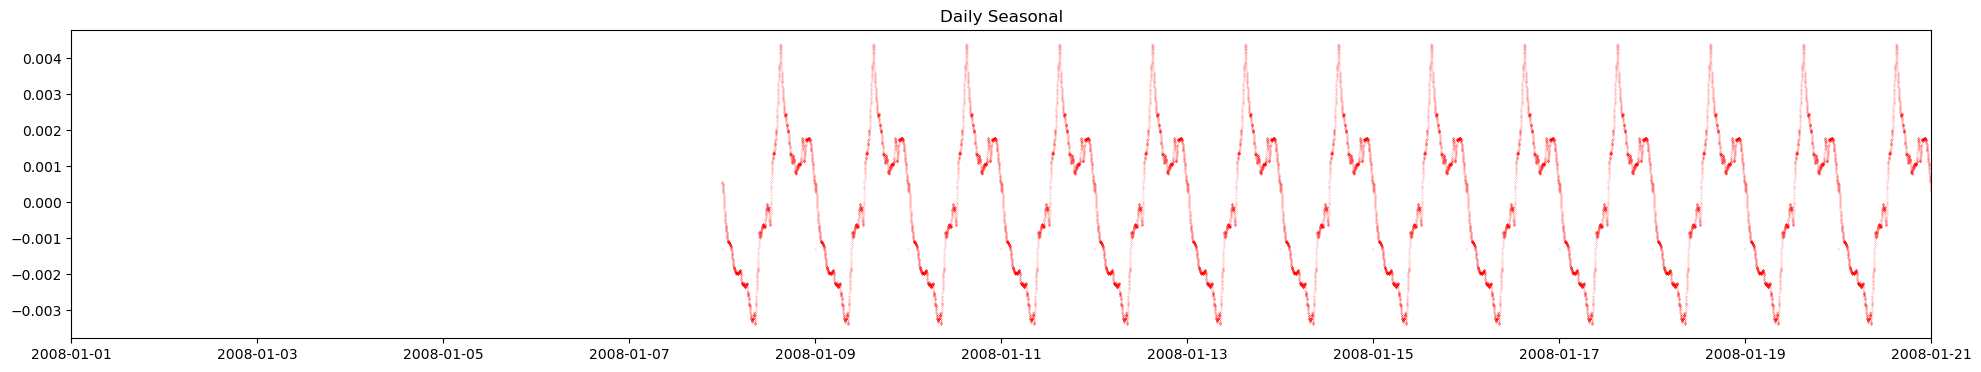

In [6]:
daily_decomposition = seasonal_decompose(
    weekly_trend.dropna(), model="additive", period=DAY_PERIOD, two_sided=False
)
daily_trend = daily_decomposition.trend
Y = daily_decomposition.seasonal.to_frame(name="power")
fig, ax = plt.subplots(figsize=(24, 4))
ax.set_xlim(np.datetime64(START_DATE), np.datetime64(END_DATE))
ax.scatter(Y.index, Y["power"], color="red", s=0.01)
plt.title("Daily Seasonal")
plt.savefig("./figs/daily_decomposition.png")

12 hourly decomposition

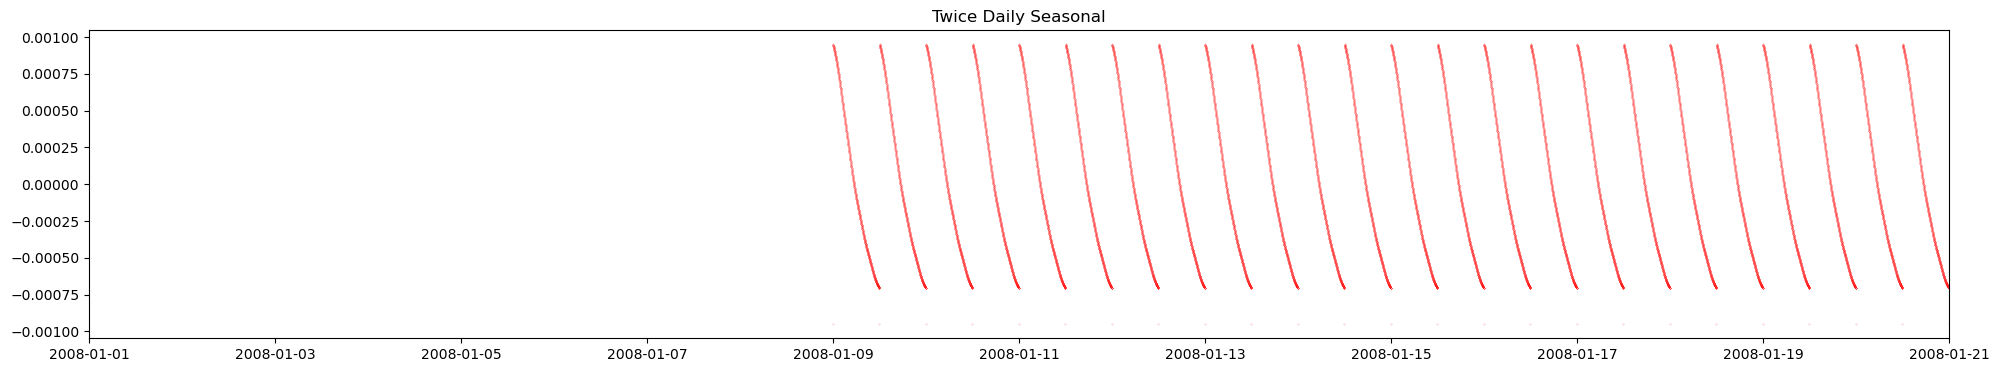

In [8]:
h12_decomposition = seasonal_decompose(
    daily_trend.dropna(), model="additive", period=H12_PERIOD, two_sided=False
)
h12_trend = h12_decomposition.trend
Y = h12_decomposition.seasonal.to_frame(name="power")
fig, ax = plt.subplots(figsize=(24, 4))
ax.set_xlim(np.datetime64(START_DATE), np.datetime64(END_DATE))
ax.scatter(Y.index, Y["power"], color="red", s=0.01)
plt.title("Twice Daily Seasonal")
plt.savefig("./figs/h12_decomposition.png")

Hourly decomposition

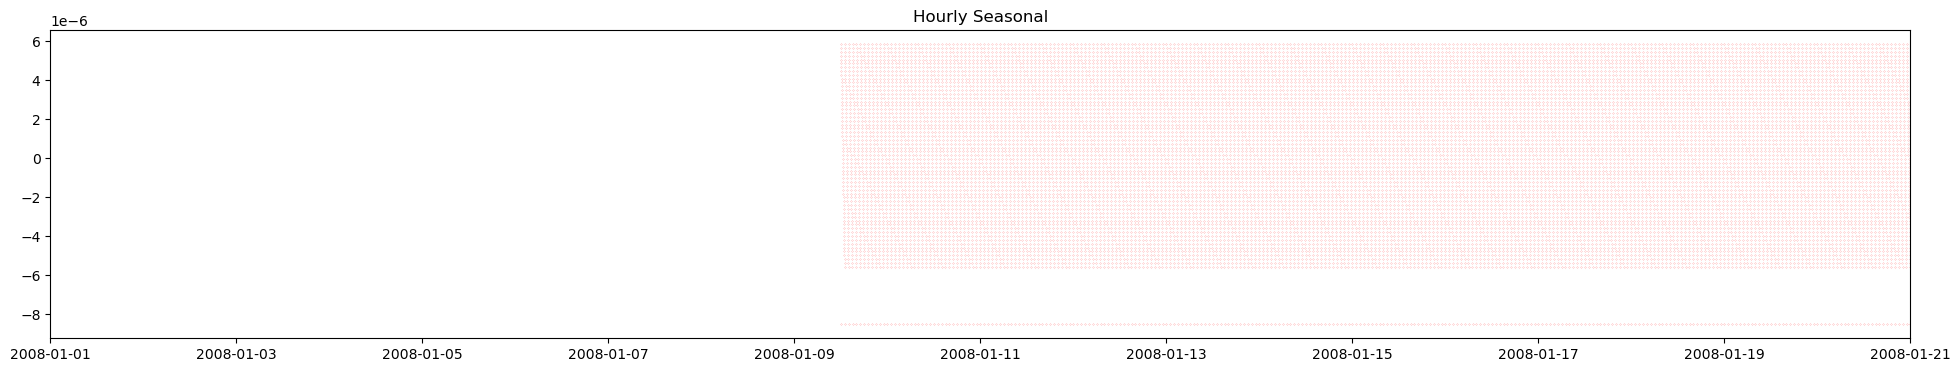

In [9]:
hourly_decomposition = seasonal_decompose(
    h12_trend.dropna(), model="additive", period=HOUR_PERIOD, two_sided=False
)
hourly_trend = hourly_decomposition.trend
Y = hourly_decomposition.seasonal.to_frame(name="power")
fig, ax = plt.subplots(figsize=(24, 4))
ax.set_xlim(np.datetime64(START_DATE), np.datetime64(END_DATE))
ax.scatter(Y.index, Y["power"], color="red", s=0.01)
plt.title("Hourly Seasonal")
plt.savefig("./figs/hourly_decomposition.png")


Now calculate and plot the residual

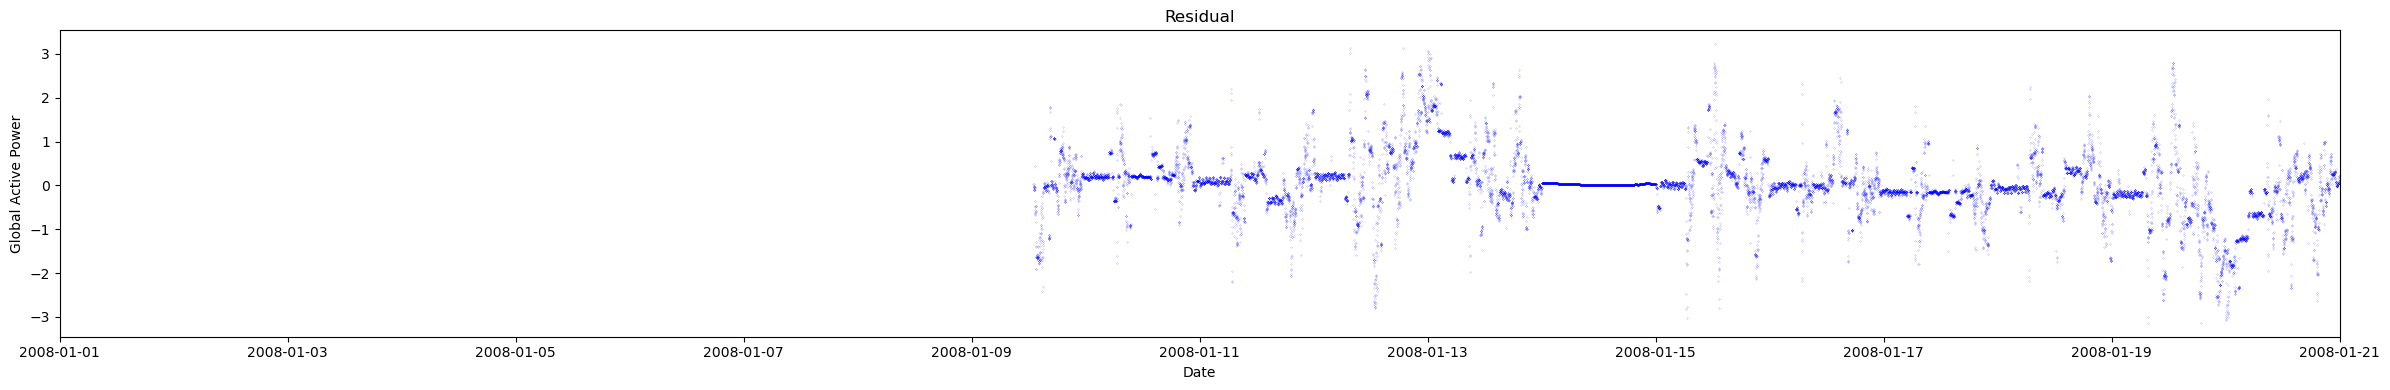

In [10]:
power = X["power"]
residual = (
    power
    - hourly_trend
    - h12_decomposition.seasonal
    - hourly_decomposition.seasonal
    - daily_decomposition.seasonal
    - weekly_decomposition.seasonal
)
residual = residual.to_frame(name="power")

fig, ax = plt.subplots(figsize=(24, 4))
ax.set_xlim(np.datetime64(START_DATE), np.datetime64(END_DATE))
ax.scatter(residual.index, residual["power"], color="blue", s=0.01)
plt.title("Residual")

plt.xlabel("Date")
plt.ylabel("Global Active Power")

plt.tight_layout()
plt.savefig("./figs/residual.png")
